# Author
- Jiapeng Sun
- jsun@student.chalmers.se

- Hao Xu
- xhao@student.chalmers.se


# Part 1: Prediction quality vs feature selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

## 1.1 Single simulation \\ single n and p

### 1.1.1 Simulate data

In [4]:
X, y, W = simulate_data(p=1000, n=700, rng=np.random)
Wcode_original = [int(x!=0) for x in W]

### 1.1.2 Determine λmin and λ1se

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

alphas = np.arange(0.01, 3, 0.1)
kfold = KFold(n_splits=5, random_state=1234, shuffle=True)
reg = LassoCV(cv=kfold, alphas=alphas, max_iter=100000)
reg.fit(X_train, y_train)

cv_mean = np.mean(reg.mse_path_, axis=1)
cv_std = np.std(reg.mse_path_, axis=1)
idx_min_mean = np.argmin(cv_mean)
idx_alpha = np.where(
    (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
    (cv_mean >= cv_mean[idx_min_mean])
)[0][0]
alpha_1se = round(reg.alphas_[idx_alpha],2)

print("Lambda min is ",reg.alpha_,"\nLambda 1se is ",alpha_1se)

Lambda min is  1.2100000000000002 
Lambda 1se is  2.21


In [6]:
from sklearn.linear_model import Lasso

reg_min = Lasso(alpha=reg.alpha_)
reg_min.fit(X_train, y_train)

reg_1se = Lasso(alpha=alpha_1se)
reg_1se.fit(X_train, y_train)

Lasso(alpha=2.21, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### 1.1.3 Performance comparing

In [7]:
from sklearn.metrics import mean_squared_error

y_train_min = reg_min.predict(X_train)
y_test_min = reg_min.predict(X_test)
mse_train_min = round(mean_squared_error(y_train,y_train_min),2)
mse_test_min = round(mean_squared_error(y_test,y_test_min),2)

y_train_1se = reg_1se.predict(X_train)
y_test_1se = reg_1se.predict(X_test)
mse_train_1se = round(mean_squared_error(y_train,y_train_1se),2)
mse_test_1se = round(mean_squared_error(y_test,y_test_1se),2)

print(mse_train_min,mse_test_min,mse_train_1se,mse_test_1se)

277.09 550.35 461.66 650.04


In [8]:
from sklearn.metrics import classification_report

Wcode_lambda_min = [int(x!=0) for x in reg_min.coef_]
Wcode_lambda_1se = [int(x!=0) for x in reg_1se.coef_]

target_names = ['unacticve','acticve']

recall_min = classification_report(
    y_true = Wcode_original
    , y_pred = Wcode_lambda_min
    , target_names = target_names
    , output_dict = True
    )

recall_1se = classification_report(
    y_true = Wcode_original
    , y_pred = Wcode_lambda_1se
    , target_names = target_names
    , output_dict = True
    )

sensitivity_min = round(recall_min['acticve']['recall'],2)
sensitivity_1se = round(recall_1se['acticve']['recall'],2)

specificity_min = round(recall_min['unacticve']['recall'],2)
specificity_1se = round(recall_1se['unacticve']['recall'],2)

print(sensitivity_min,sensitivity_1se,specificity_min,specificity_1se)

0.69 0.57 0.91 0.98


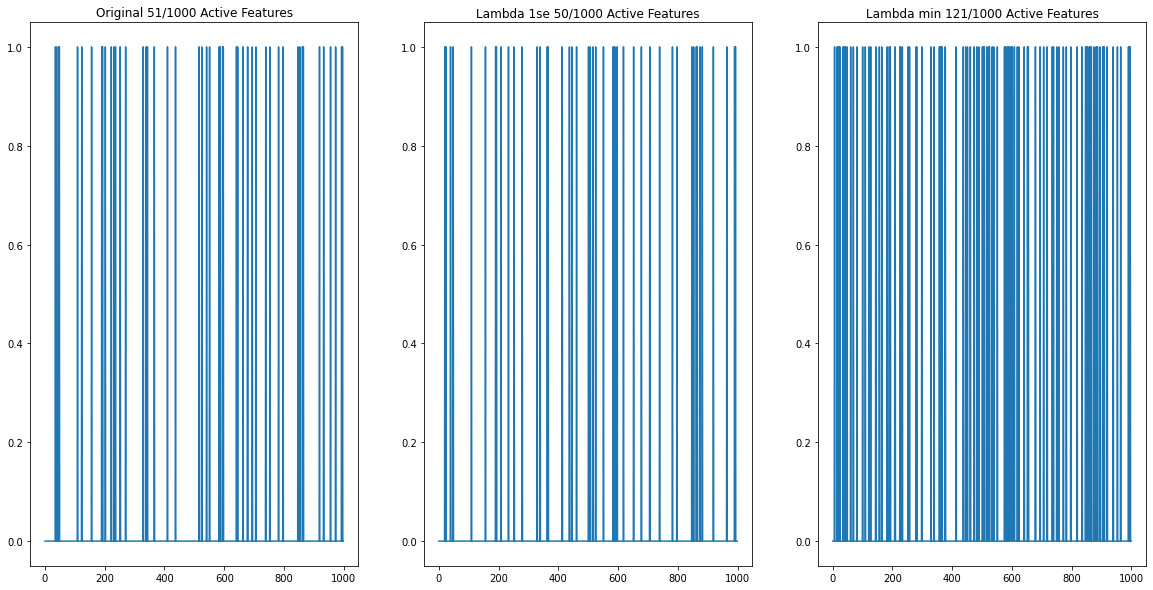

In [9]:
fig, ax = plt.subplots(1,3,figsize=(20, 10))

ax[0].plot(Wcode_original)
ax[0].set_title("Original " + str(sum(np.array(Wcode_original))) + "/" + str(len(W)) + " Active Features")

ax[1].plot(Wcode_lambda_1se)
ax[1].set_title("Lambda 1se " + str(sum(np.array(Wcode_lambda_1se))) + "/" + str(len(W)) + " Active Features")

ax[2].plot(Wcode_lambda_min)
ax[2].set_title("Lambda min " + str(sum(np.array(Wcode_lambda_min))) + "/" + str(len(W)) + " Active Features")

plt.show()

## 1.2 Repeated simulation \\ varies n and p

### 1.2.1 Simulate data

- Here we set 7 values for number of features.
- Here we set 6 values for sparsity.
- For each n/s combination, simulations are repeated 10 times.
- As result, we have 42 * 10 = 420 simlulated datasets for future use.

In [8]:
n_list = [200, 300, 400, 500, 600, 700, 800]
s_list = [0.75, 0.80, 0.85, 0.9, 0.95, 0.99]

repeat_list = []

repeat_num = 10

for i in range(repeat_num):
    cur_comb_dict = {}

    for cur_n in n_list:
        cur_n_dict = {}

        for cur_s in s_list:
            cur_s_dict = {}

            cur_X, cur_y, cur_W = simulate_data(
                n = cur_n
                , p = 1000
                , sparsity = cur_s
                , rng = np.random
                , SNR = 2.0
                , beta_scale = 5.0
                )
            
            cur_Wcode = [int(x!=0) for x in cur_W]
            
            cur_s_dict ['X'] = cur_X
            cur_s_dict ['y'] = cur_y
            # cur_s_dict ['W'] = cur_W
            cur_s_dict ['Wcode'] = cur_Wcode
    
            cur_n_dict[cur_s] = cur_s_dict
        
        cur_comb_dict[cur_n] = cur_n_dict

    repeat_list.append(cur_comb_dict)

### 1.2.2 Calculate preformance metrics

- For each data set from above, we split it into train and test set with default settings.
- We get $\lambda_{min}$ from LassoCV function fit on train set first, then calculate $\lambda_{1se}$ based on it.
- Based on $\lambda_{min}$ and $\lambda_{1se}$ from above, we implement Lasso model fit on train set seperately.
    - We calculate the MSE for both $\lambda_{min}$ and $\lambda_{1se}$ on both train and test set.
    - We encoded the weights from original data and seleciton from model into binary codes. 
    - We calculate the sensitivity and specificity on feature selection for both $\lambda_{min}$ and $\lambda_{1se}$ models.

In [9]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

from IPython.display import clear_output

repeat_res = []
for i,cur_repeat in enumerate(repeat_list):
    
    cur_repeat_res = []
    for cur_n in cur_repeat.keys():
        for cur_s in cur_repeat[cur_n].keys():

            print("Repeat: {} \nNumber of features: {} \nSparsity: {}".format(i+1,cur_n,cur_s))
            clear_output(wait=True)

            X = cur_repeat[cur_n][cur_s]['X']
            y = cur_repeat[cur_n][cur_s]['y']
            Wcode_original = cur_repeat[cur_n][cur_s]['Wcode']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, random_state=0
                )

            alphas = np.arange(0.01, 3, 0.1)
            kfold = KFold(n_splits=5, random_state=1234, shuffle=True)
            reg = LassoCV(cv=kfold, alphas=alphas, max_iter=100000)
            reg.fit(X_train, y_train)

            cv_mean = np.mean(reg.mse_path_, axis=1)
            cv_std = np.std(reg.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
                (cv_mean >= cv_mean[idx_min_mean])
                )[0][0]
            alpha_1se = round(reg.alphas_[idx_alpha],2)

            reg_min = Lasso(alpha=reg.alpha_)
            reg_min.fit(X_train, y_train)

            reg_1se = Lasso(alpha=alpha_1se)
            reg_1se.fit(X_train, y_train)

            y_train_min = reg_min.predict(X_train)
            y_test_min = reg_min.predict(X_test)
            mse_train_min = round(mean_squared_error(y_train,y_train_min),2)
            mse_test_min = round(mean_squared_error(y_test,y_test_min),2)

            y_train_1se = reg_1se.predict(X_train)
            y_test_1se = reg_1se.predict(X_test)
            mse_train_1se = round(mean_squared_error(y_train,y_train_1se),2)
            mse_test_1se = round(mean_squared_error(y_test,y_test_1se),2)


            Wcode_lambda_min = [int(x!=0) for x in reg_min.coef_]
            Wcode_lambda_1se = [int(x!=0) for x in reg_1se.coef_]

            target_names = ['unacticve','acticve']

            recall_min = classification_report(
                y_true = Wcode_original
                , y_pred = Wcode_lambda_min
                , target_names = target_names
                , output_dict = True
            )

            recall_1se = classification_report(
                y_true = Wcode_original
                , y_pred = Wcode_lambda_1se
                , target_names = target_names
                , output_dict = True
            )

            sensitivity_min = round(recall_min['acticve']['recall'],2)
            sensitivity_1se = round(recall_1se['acticve']['recall'],2)

            specificity_min = round(recall_min['unacticve']['recall'],2)
            specificity_1se = round(recall_1se['unacticve']['recall'],2)

            all_info = [
                        cur_n
                        ,cur_s
                        ,mse_train_min
                        ,mse_train_1se
                        ,mse_test_min
                        ,mse_test_1se
                        ,sensitivity_min
                        ,sensitivity_1se
                        ,specificity_min
                        ,specificity_1se
                        ]
            
            cur_repeat_res.append(all_info)
    
    repeat_res.append(cur_repeat_res)

Repeat: 10 
Number of features: 800 
Sparsity: 0.99


### 1.2.3 Performance Evaluation

- For each n/s combinition, we take the average value for each performance metric on the 10 repeated results.
- When doing visulazation, we also draw the 95% confidence interval for each metric.

In [43]:
import pandas as pd

df_res = np.array(repeat_res)
df_res = np.average(df_res,axis=0)
df_res = pd.DataFrame(df_res)
df_res.columns = [
              'n','s'
              ,'mse_train_min','mse_train_1se'
              ,'mse_test_min','mse_test_1se'
              ,'sensitivity_min','sensitivity_1se'
              ,'specificity_min','specificity_1se'
              ]
df_res.head()

,n,s,mse_train_min,mse_train_1se,mse_test_min,mse_test_1se,sensitivity_min,sensitivity_1se,specificity_min,specificity_1se
0,200.0,0.75,394.096,450.495,8430.712,8387.373,0.168,0.167,0.901,0.905
1,200.0,0.80,406.926,449.266,6784.780,6757.475,0.189,0.183,0.908,0.911
2,200.0,0.85,280.255,412.503,4874.140,4759.323,0.221,0.204,0.905,0.919
3,200.0,0.90,398.231,412.807,2587.410,2575.213,0.250,0.248,0.924,0.926
4,200.0,0.95,272.585,334.785,1043.742,1024.037,0.354,0.341,0.937,0.946


In [44]:
df_std = pd.DataFrame(np.std(np.array(repeat_res),axis=0))
df_std.columns = [
              'n','s'
              ,'mse_train_min','mse_train_1se'
              ,'mse_test_min','mse_test_1se'
              ,'sensitivity_min','sensitivity_1se'
              ,'specificity_min','specificity_1se'
              ]
df_std.n = df_res.n
df_std.s = df_res.s
df_std.head()

,n,s,mse_train_min,mse_train_1se,mse_test_min,mse_test_1se,sensitivity_min,sensitivity_1se,specificity_min,specificity_1se
0,200.0,0.75,90.232672,25.801858,2610.769019,2651.123198,0.016000,0.016763,0.007000,0.006708
1,200.0,0.80,136.724580,24.241946,1621.118474,1577.466680,0.021656,0.017349,0.015362,0.009434
2,200.0,0.85,177.908360,22.889248,1215.522860,1239.524591,0.029138,0.027641,0.018574,0.009434
3,200.0,0.90,58.937606,29.904876,554.978823,542.144767,0.028983,0.026758,0.010198,0.009165
4,200.0,0.95,113.889983,32.823733,334.174568,346.035911,0.043635,0.061717,0.015524,0.009165


#### 1.2.3.1 MSE
- When visulazing the MSE on sparsity for $\lambda_{min}$ and $\lambda_{1se}$, we fixed 700 as number of features to avoid optim n value, since it may leads to low difference on MSE for different s value.
    - Compare with model based on $\lambda_{1se}$, the one with $\lambda_{min}$ shows better performance since more features are selected.
    - MSE reachs the similar value for $\lambda_{min}$ and $\lambda_{1se}$ on all sets with 0.99 sparsity. 
    - As sparsity increases:
        - The MSE shows gentle decrease on train set.
        - The MSE shows sharp decrease on test set.
        - The gap between MSE shows decrease on both train and test set.
    - The reason why higher sparsity leads to bettter performance, may beacause that it leads to a more simple corrleation as more weights are set to zero, which can be captured by the model easier as the result.
 
- When visulazing the MSE on different number of features, we fixed 0.99 as value of sparsity, to avoid optim s value, since it may leads to low difference on MSE for different n value.
    - Compare with model based on $\lambda_{1se}$, the one with $\lambda_{min}$ shows better performance since more features are selected.
    - As number of features increases:
        - The MSE shows unstable decrease trend on both train and test set.
        - The gap between MSE shows decrease on both train and test set.
    - The reason why higher number of features leads to bettter performance, may beacause that it leads a model with more corrleations, which can reduce the affect of mis-selected features.

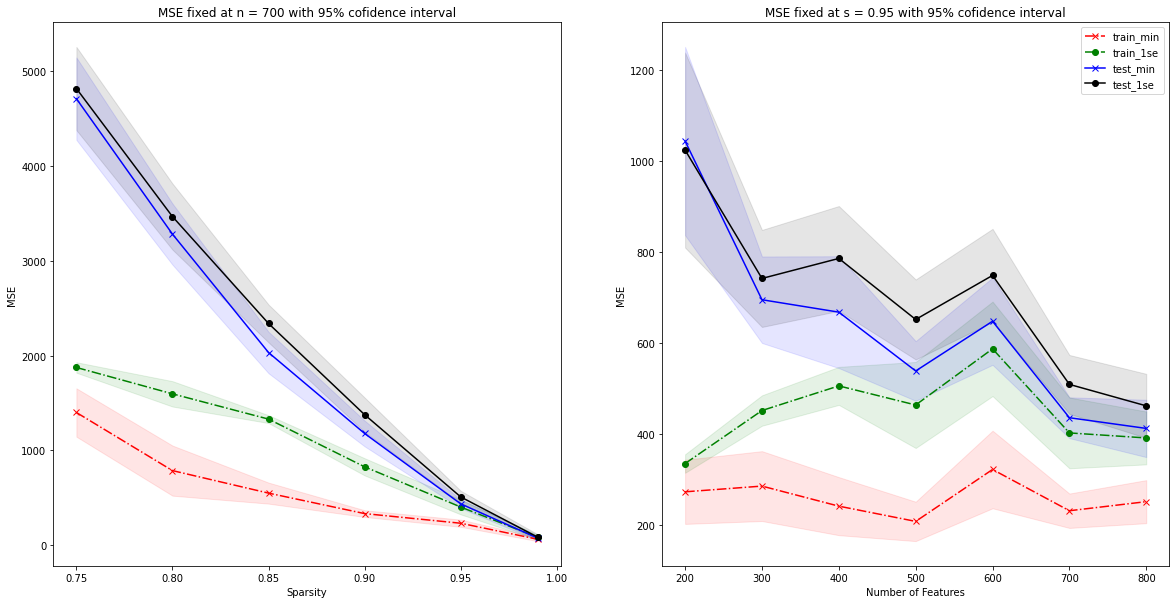

In [69]:
fig = plt.figure(figsize=(20,10))

t = df_res.query("n == 700")
c = df_std.query("n == 700")

ax1 = fig.add_subplot(121)

y = 'mse_train_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y], color='r', label='train_min', marker='x',linestyle='-.')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='r', alpha=.1)

y = 'mse_train_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y], color='g', label='train_1se', marker='o',linestyle='-.')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='g', alpha=.1)

y = 'mse_test_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y],  color='b', label='test_min', marker='x',linestyle='-')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='b', alpha=.1)

y = 'mse_test_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y], color='k', label='test_1se', marker='o',linestyle='-')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='k', alpha=.1)

ax1.set_title('MSE fixed at n = 700 with 95% cofidence interval')
ax1.set_xlabel('Sparsity')
ax1.set_ylabel('MSE')


t = df_res.query("s == 0.95")
c = df_std.query("s == 0.95")

ax2 = fig.add_subplot(122)

y = 'mse_train_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y], color='r', label='train_min', marker='x',linestyle='-.')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='r', alpha=.1)

y = 'mse_train_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y], color='g', label='train_1se', marker='o',linestyle='-.')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='g', alpha=.1)

y = 'mse_test_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y],  color='b', label='test_min', marker='x',linestyle='-')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='b', alpha=.1)

y = 'mse_test_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y], color='k', label='test_1se', marker='o',linestyle='-')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='k', alpha=.1)

ax2.set_title('MSE fixed at s = 0.95 with 95% cofidence interval')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('MSE')

plt.legend()
plt.show()

#### 1.2.3.2 Sensitivity and Specificity

- When visulazing the Recall on sparsity for $\lambda_{min}$ and $\lambda_{1se}$, we fixed 700 as number of features to avoid optim n value, since it may leads to low difference on MSE for different s value.

    - Compare with model based on $\lambda_{1se}$, the one with $\lambda_{min}$ shows:

        - Lower sensitivity since less features are selected.
        
        - Higher specificity since less features are selected.

    - As sparsity increases, the gap between Recalls on $\lambda_{min}$ and $\lambda_{1se}$ shows decrease on both sensitivity and specificity.

    - The reason why higher sparsity leads lower gap, may beacuse it leads to a more simple corrleation as more weights are set to zero, which can be captures by the model easier.
 
- When visulazing the Recall on different number of features, we fixed 0.99 as value of sparsity, to avoid optim s value, since it may leads to low difference on MSE for different n value.

    - Compare with model based on $\lambda_{1se}$, the one with $\lambda_{min}$ shows:

        - Lower sensitivity since less features are selected.
        
        - Higher specificity since less features are selected.

    - As number of features increases, the gap between Recalls on $\lambda_{min}$ and $\lambda_{1se}$ shows increase on both sensitivity and specificity.

    - The reason why higher number of features leads to higher gap,, may beacause that it leads a model with more corrleations, which makes it harder to be captured by the model.

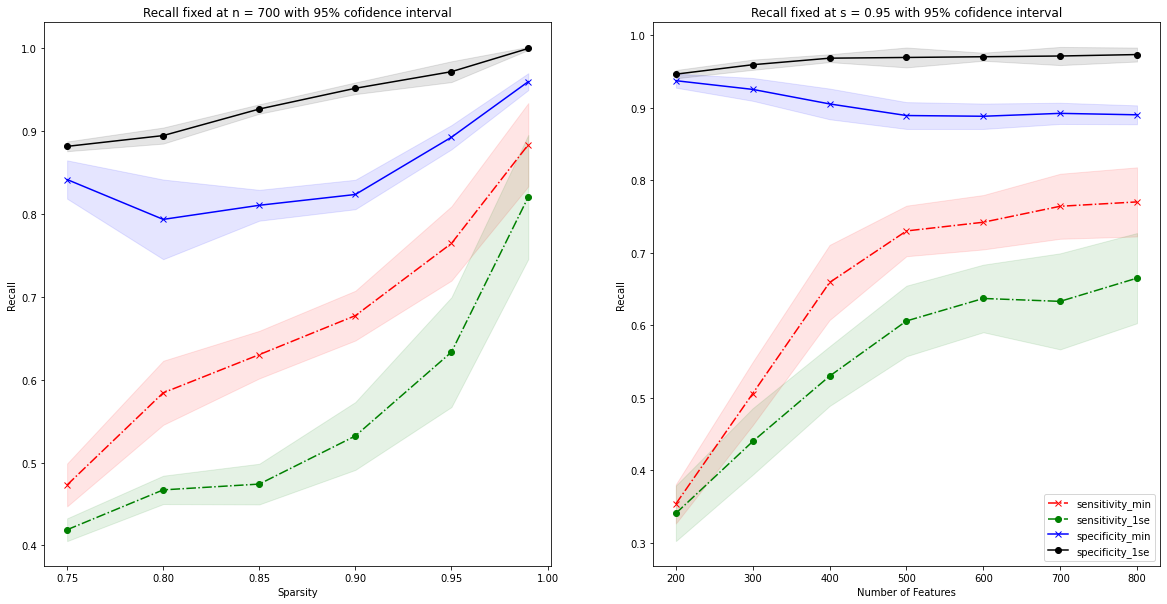

In [70]:
fig = plt.figure(figsize=(20,10))

t = df_res.query("n == 700")
c = df_std.query("n == 700")

ax1 = fig.add_subplot(121)

y = 'sensitivity_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y], color='r', label='sensitivity_min', marker='x',linestyle='-.')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='r', alpha=.1)

y = 'sensitivity_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y], color='g', label='sensitivity_1se', marker='o',linestyle='-.')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='g', alpha=.1)

y = 'specificity_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y],  color='b', label='specificity_min', marker='x',linestyle='-')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='b', alpha=.1)

y = 'specificity_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax1.plot(t.s, t[y], color='k', label='specificity_1se', marker='o',linestyle='-')
ax1.fill_between(t.s, t[y] - c_95, t[y] + c_95, color='k', alpha=.1)

ax1.set_title('Recall fixed at n = 700 with 95% cofidence interval')
ax1.set_xlabel('Sparsity')
ax1.set_ylabel('Recall')


t = df_res.query("s == 0.95")
c = df_std.query("s == 0.95")

ax2 = fig.add_subplot(122)

y = 'sensitivity_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y], color='r', label='sensitivity_min', marker='x',linestyle='-.')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='r', alpha=.1)

y = 'sensitivity_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y], color='g', label='sensitivity_1se', marker='o',linestyle='-.')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='g', alpha=.1)

y = 'specificity_min'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y],  color='b', label='specificity_min', marker='x',linestyle='-')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='b', alpha=.1)

y = 'specificity_1se'
c_95 = 1.96 * c[y] / np.sqrt(len(repeat_res))
ax2.plot(t.n, t[y], color='k', label='specificity_1se', marker='o',linestyle='-')
ax2.fill_between(t.n, t[y] - c_95, t[y] + c_95, color='k', alpha=.1)

ax2.set_title('Recall fixed at s = 0.95 with 95% cofidence interval')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Recall')

plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D

# df = df_res
# sns.set(style = "darkgrid")

# fig = plt.figure(figsize=(20,8))

# x = df['n']
# y = df['s']

# ax1 = fig.add_subplot(121, projection = '3d')

# z1 = df['mse_train_min']
# z2 = df['mse_train_1se']
# z3 = df['mse_test_min']
# z4 = df['mse_test_1se']

# ax1.set_xlabel("Number of features")
# ax1.set_ylabel("Sparsity")
# ax1.set_zlabel("MSE")

# ax1.scatter(x, y, z1, label='train_min', depthshade=False)
# ax1.scatter(x, y, z2, label='train_1se', depthshade=False)
# ax1.scatter(x, y, z3, label='test_min', depthshade=False)
# ax1.scatter(x, y, z4, label='test_1se', depthshade=False)

# ax1.set_title('MSE Score')
# ax1.legend()

# ax2 = fig.add_subplot(122, projection = '3d')

# k1 = df['sensitivity_min']
# k2 = df['sensitivity_1se']
# k3 = df['specificity_min']
# k4 = df['specificity_1se']

# ax2.set_xlabel("Number of features")
# ax2.set_ylabel("Sparsity")
# ax2.set_zlabel("Recall")

# ax2.scatter(x, y, k1, label='sensitivity_min', depthshade=False)
# ax2.scatter(x, y, k2, label='sensitivity_1se', depthshade=False)
# ax2.scatter(x, y, k3, label='specificity_min', depthshade=False)
# ax2.scatter(x, y, k4, label='specificity_1se', depthshade=False)

# ax2.set_title('Recall Score')
# ax2.legend()

# plt.show()

# Part 2: Selecting features with confidence

In [34]:
!wget https://github.com/JiapengSun/CTH_course_data/raw/master/MVE441AS3/data.zip -O data.zip
!wget https://github.com/JiapengSun/CTH_course_data/raw/master/MVE441AS3/labels.csv -O labels.csv

!unzip -uq data.zip -d ./

--2021-05-21 10:34:56--  https://github.com/JiapengSun/CTH_course_data/raw/master/MVE441AS3/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JiapengSun/CTH_course_data/master/MVE441AS3/data.zip [following]
--2021-05-21 10:34:56--  https://raw.githubusercontent.com/JiapengSun/CTH_course_data/master/MVE441AS3/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72882160 (70M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  69.50M   179MB/s    in 0.4s    

2021-05-21 10:34:57 (179 MB/s) - ‘data.zip’ saved [72882160/72882160]

--2021-05-21 10:34:5

In [35]:
import pandas as pd
import numpy as np

gene_df = pd.read_csv('./data.csv', index_col=0)
label_df = pd.read_csv('./labels.csv', index_col=0)

In [36]:
gene_df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29,gene_30,gene_31,gene_32,gene_33,gene_34,gene_35,gene_36,gene_37,gene_38,gene_39,...,gene_20491,gene_20492,gene_20493,gene_20494,gene_20495,gene_20496,gene_20497,gene_20498,gene_20499,gene_20500,gene_20501,gene_20502,gene_20503,gene_20504,gene_20505,gene_20506,gene_20507,gene_20508,gene_20509,gene_20510,gene_20511,gene_20512,gene_20513,gene_20514,gene_20515,gene_20516,gene_20517,gene_20518,gene_20519,gene_20520,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,0.591871,1.334282,2.015391,0.591871,0.0,0.0,0.0,0.0,0.591871,5.619994,1.334282,0.000000,9.796088,0.0,0.000000,1.598651,7.215116,10.839070,6.620204,9.513538,0.0,4.063658,7.764805,4.747656,13.714396,10.034496,0.000000,0.0,9.833458,0.000000,...,9.370304,10.362393,5.589928,8.141964,0.000000,2.736583,7.037152,7.123480,10.967399,5.902800,3.719370,7.203554,6.042557,2.602077,7.425526,7.846957,2.824951,6.239396,0.000000,8.469593,0.0,6.535978,6.968701,7.128881,7.175175,9.249369,7.025970,8.045563,7.475709,7.205236,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,0.000000,0.587845,2.466601,1.004394,0.0,0.0,0.0,0.0,0.000000,11.055208,3.562621,0.000000,10.070470,0.0,0.000000,0.000000,9.949812,8.522476,1.174790,4.926991,0.0,0.000000,5.819832,1.327170,13.286240,6.663316,0.587845,0.0,9.533302,0.811142,...,8.882967,9.898199,7.069401,7.186134,0.000000,3.134993,6.648930,6.715701,9.536238,1.004394,5.555482,8.029260,6.366219,0.811142,7.991732,7.161001,0.000000,4.708877,0.811142,8.451689,0.0,7.242336,8.046284,6.047558,8.572901,7.549030,7.019935,9.458940,9.190867,10.639259,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,0.000000,0.452595,1.981122,1.074163,0.0,0.0,0.0,0.0,1.683023,8.210248,4.195285,3.660427,8.970920,0.0,0.000000,0.796598,6.096650,9.861616,7.680507,3.119439,0.0,0.452595,7.899526,0.000000,10.731098,6.967883,0.452595,0.0,9.646323,0.452595,...,10.355637,10.423274,5.170201,6.194260,0.000000,3.677147,6.271990,7.089816,9.675220,0.000000,4.224017,8.020402,6.967883,5.014445,8.400038,7.527555,0.000000,4.997902,0.796598,7.761132,0.0,6.820460,8.048983,6.661493,7.716332,6.745802,7.524667,8.602350,9.036654,10.336027,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,0.000000,0.434882,2.874246,0.000000,0.0,0.0,0.0,0.0,1.267356,8.306317,3.573556,0.000000,8.524616,0.0,0.000000,0.000000,3.913761,9.511573,6.469165,7.029895,0.0,1.267356,6.800641,7.742714,12.659474,8.299890,0.768587,0.0,9.670731,0.434882,...,10.074382,9.918261,7.117924,7.196145,0.434882,3.609755,8.896696,7.577096,10.731446,5.075383,2.175652,7.675435,6.840816,6.233192,8.899886,8.319085,1.791814,5.661134,1.464093,8.625727,0.0,7.420095,7.784746,7.613915,8.963286,7.744699,7.924997,8.981473,8.665592,9.194823,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,0.000000,1.275841,2.141204,0.000000,0.0,0.0,0.0,0.0,0.889707,10.149150,2.967630,0.000000,8.047238,0.0,1.435949,0.000000,1.942120,8.821535,5.861429,7.755709,0.0,0.649386,5.570241,2.612801,13.556734,8.004754,0.000000,0.0,9.587569,0.649386,...,10.129154,10.062303,6.911620,7.855149,0.360982,3.655810,7.255520,7.292607,10.779793,3.954001,6.991148,8.153248,7.508444,4.586531,9.152227,8.227717,0.360982,6.227104,0.649386,8.151879,0.0,6.558289,8.673708,6.505099,8.948989,7.010

In [187]:
# label_dict = {}
# for i,l in enumerate(label_df.Class.unique()):
#     label_dict[l] = str(i)
# y_code = [label_dict[x] for x in label_df.Class]
# y_code = np.array(y_code)

## 2.1 Feature reduction

- Here we select 200 features for future use using the F statistic

In [37]:
from sklearn.feature_selection import SelectKBest

gene_200 = SelectKBest(k = 200).fit_transform(gene_df, label_df)
gene_200.shape

X = np.array(gene_200)
y = np.array(label_df.Class)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [    5    23  4370  4808  4809  4814  4816  4817  4831  5288  7661  7662
  7663  7664  7665  8121  9304  9306  9314  9316  9320  9452 10121 11958
 13991 14158 14159 14161 15138 15140 15141 15446 16566 16568 16569 16571
 16575 16578 16579 16604 16634 16637 16677 16697 16698 16699 16700 16701
 16702 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713 16714
 16715 16716 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726
 16727 16728 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738
 16739 16740 16741 16742 16743 16744 16745 16746 16748 16749 16750 16751
 16752 16753 16754 16756 16757 16758 1

## 2.2 Performing feature selection

- Here we implement with LogisticRegressionCV function with *one over rest* setting.
- By such function, we find the value of $C_{max}$ and respected weights for each single class.
- We encoded the weights into binary codes for future use.

In [38]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV

import numpy as np
C_list = np.logspace(-5, 5, 50).tolist()

kfold = KFold(n_splits=5, random_state=1234, shuffle=True)
lrcv = LogisticRegressionCV(
    Cs = C_list
    ,cv=kfold
    ,multi_class='ovr'
    ,solver='liblinear'
    ,intercept_scaling=10000
    ,max_iter=100000
    ,scoring = 'accuracy'
    ,penalty = 'l1'
    )
lrcv.fit(X,y)

Wcode_C_max = [[int(x!=0) for x in coef] for coef in lrcv.coef_]
# np.sum(np.array(Wcode_C_max),axis=1)
print(lrcv.C_)

[2.02358965e+00 3.55648031e+02 2.12095089e+01 3.39322177e+01
 2.81176870e-03]


In [190]:
# C_1se = []
# for cur_class in lrcv.scores_.keys():
#     cv_mean = np.mean(lrcv.scores_[cur_class], axis=1)
#     cv_std = np.std(lrcv.scores_[cur_class], axis=1)
#     idx_min_mean = np.argmin(cv_mean)
#     idx_alpha = np.where(
#         (cv_mean <= cv_mean[idx_min_mean]) &
#         (cv_mean >= cv_mean[idx_min_mean] - cv_std[idx_min_mean])
#     )[0][0]
#     cur_1se = lrcv.Cs_[idx_alpha]
#     C_1se.append(cur_1se)

# C_max = lrcv.C_.tolist()
# print("C_max ",C_max,"\nC_1se ",C_1se)

In [191]:
# from sklearn.linear_model import LogisticRegression

# C_max_avg = np.mean(C_max)
# C_1se_avg = np.mean(C_1se)

# lr_max = LogisticRegression(
#     C = C_max_avg
#     ,multi_class = 'ovr'
#     ,solver = 'liblinear'
#     ,intercept_scaling = 10000
#     ,max_iter = 100000
#     ,penalty = 'l1'
#     )

# lr_1se = LogisticRegression(
#     C = C_1se_avg
#     ,multi_class = 'ovr'
#     ,solver = 'liblinear'
#     ,intercept_scaling = 10000
#     ,max_iter = 100000
#     ,penalty = 'l1'
#     )    

# lr_max.fit(X,y)
# lr_1se.fit(X,y)

# Wcode_C_max = [[int(x!=0) for x in coef] for coef in lr_max.coef_]
# Wcode_C_1se = [[int(x!=0) for x in coef] for coef in lr_1se.coef_]

# print(np.sum(np.array(Wcode_C_max),axis=1),'\n',np.sum(np.array(Wcode_C_1se),axis=1))

## 2.3 Gaining confidence in the selection

### 2.3.1 Bootstrapping Simulation

- Here we still use the LogisticRegressionCV as above to find relative values as above.

- We introduced bootstrap 100 times, each time use 35% of the data.

In [192]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV

import numpy as np
C_list = np.logspace(-5, 5, 50).tolist()
kfold = KFold(n_splits=5, random_state=1234, shuffle=True)

lrcv = LogisticRegressionCV(
    Cs = C_list
    ,cv = kfold
    ,multi_class='ovr'
    ,solver='liblinear'
    ,intercept_scaling=10000
    ,max_iter=100000
    ,scoring = 'accuracy'
    ,penalty = 'l1'
    )

lrcv.fit(X,y)
Wcode_sum = np.zeros(lrcv.coef_.shape)

In [193]:
repeat = 100
sample_size = int(0.35*len(X))
Wcode_sum = np.zeros(Wcode_sum.shape)

for i in range(repeat):
    print("Repeat: {} / {}".format(i+1,repeat))
    clear_output(wait=True)

    pick = np.random.choice(len(X), size=sample_size, replace=False)
    X_pick = X[pick]
    y_pick = y[pick]
    lrcv.fit(X_pick,y_pick)

    Wcode_C_max = [[int(x!=0) for x in coef] for coef in lrcv.coef_]
    Wcode_sum = Wcode_sum + np.array(Wcode_C_max)

print('Done!')

Done!


### 2.3.2 Result Visulization

- We draw the histplot for the feature selected frequency of each class based on the 100 times simualtion.
- For better visulize, we draw the histplot for first half and second half of features seperately.
- The hispolt shows that:
    - The selection on feature 1 and 3 shows noticeable stability, as most frequancies for different features are close to 1 or 0
    - The selection on feature 2 and 4 shows low stability, as most frequancies for different features are around 0.5
    - The selection on feature 5 shows strong stability as only 3 features has frequence 1 and all others 0
    - There are so many features that appear often in two or more classes simultaneously.

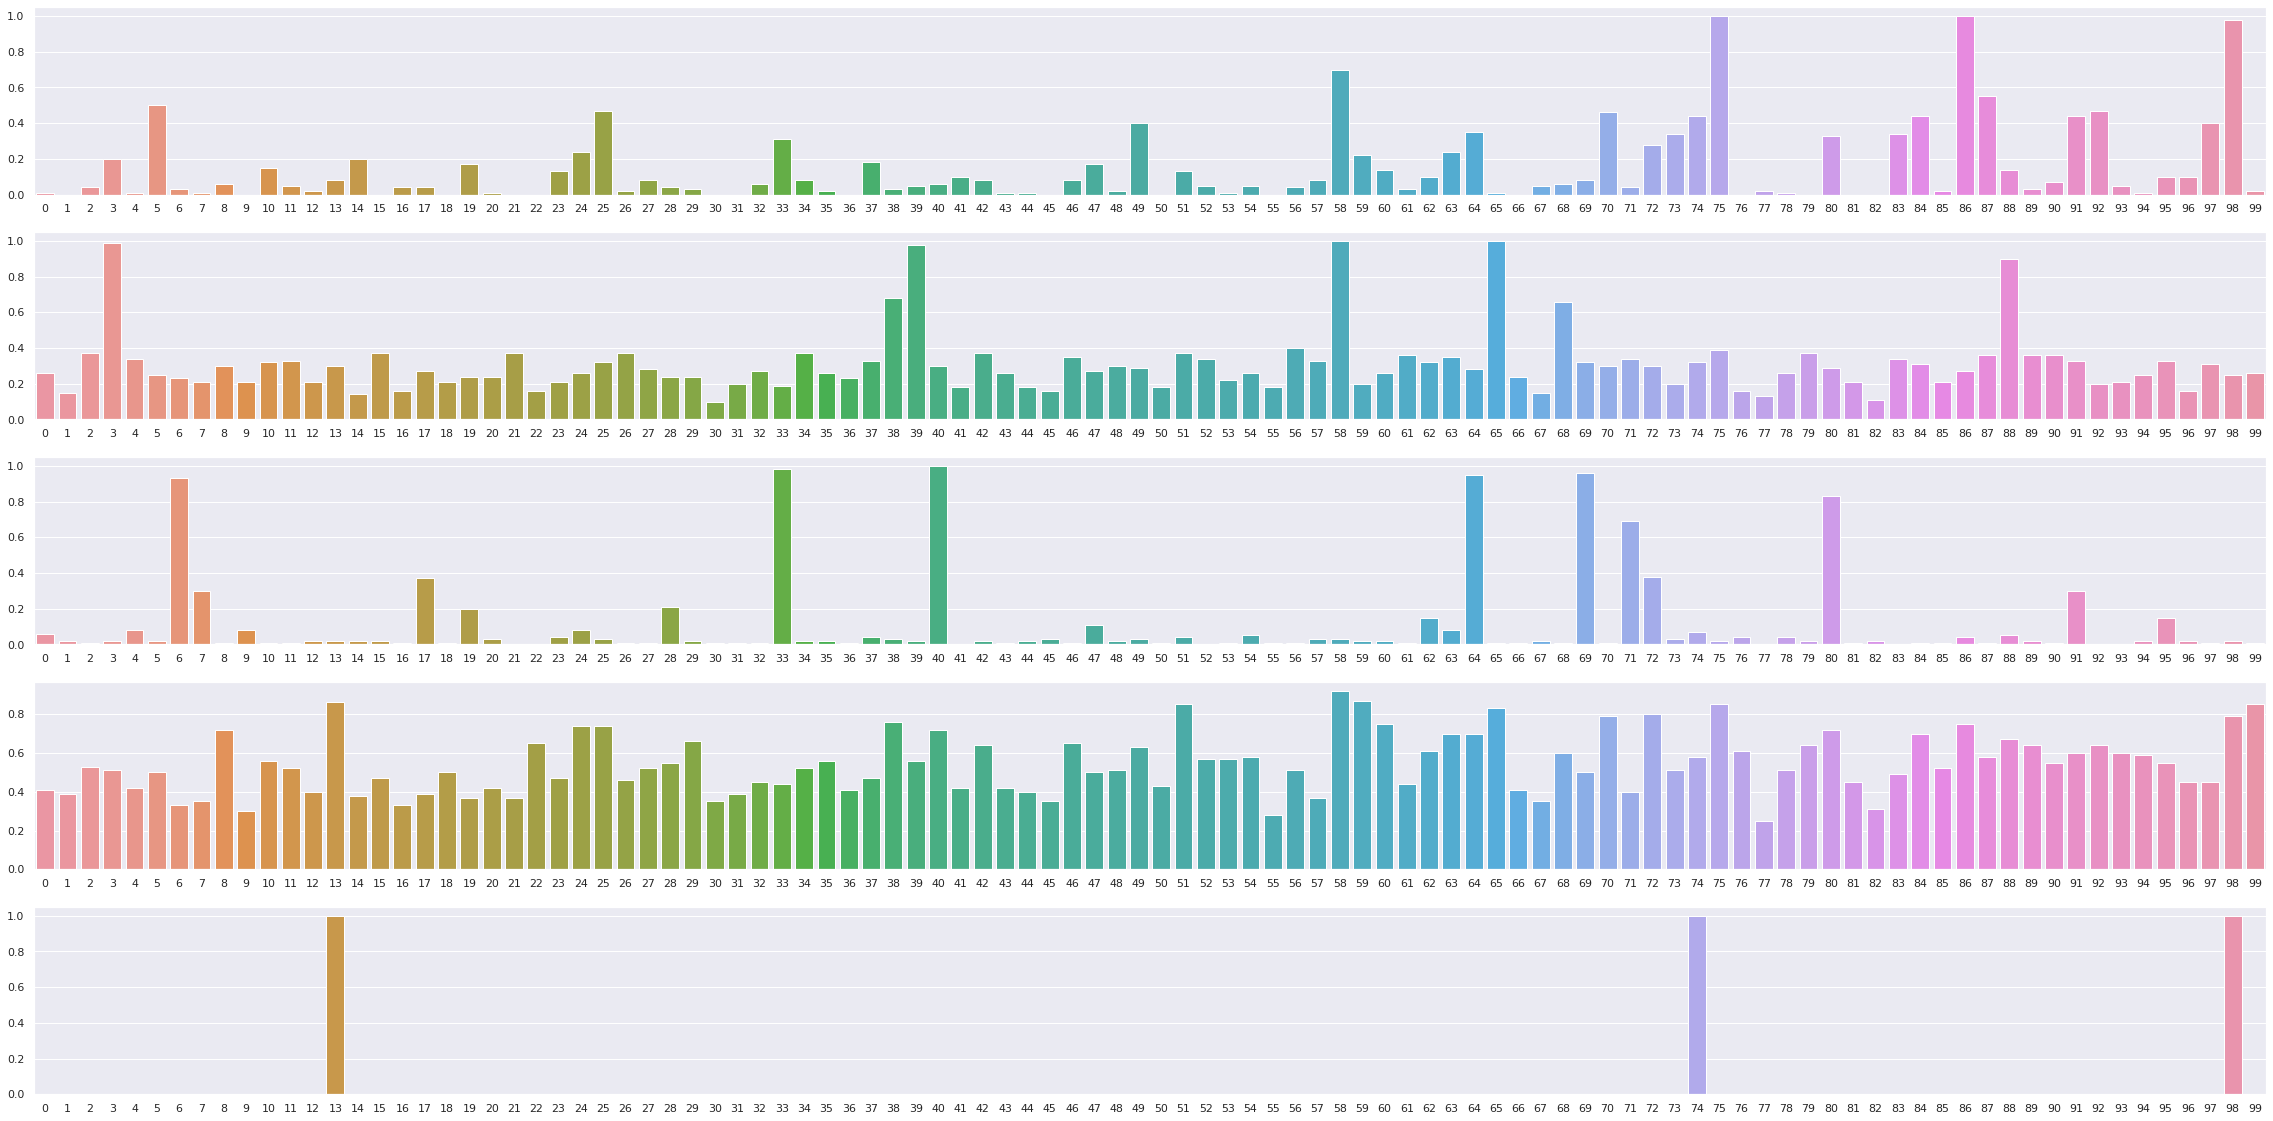

In [194]:
import seaborn as sns

x_cor = np.arange(0,Wcode_sum.shape[1])
cut = int(len(x_cor)/2)

plt.figure(figsize=(40,20))
for i,c in enumerate(Wcode_sum):
    plt.subplot(5,1,i+1)
    sns.barplot(x = x_cor[:cut], y = c[:cut]/repeat)
plt.show()

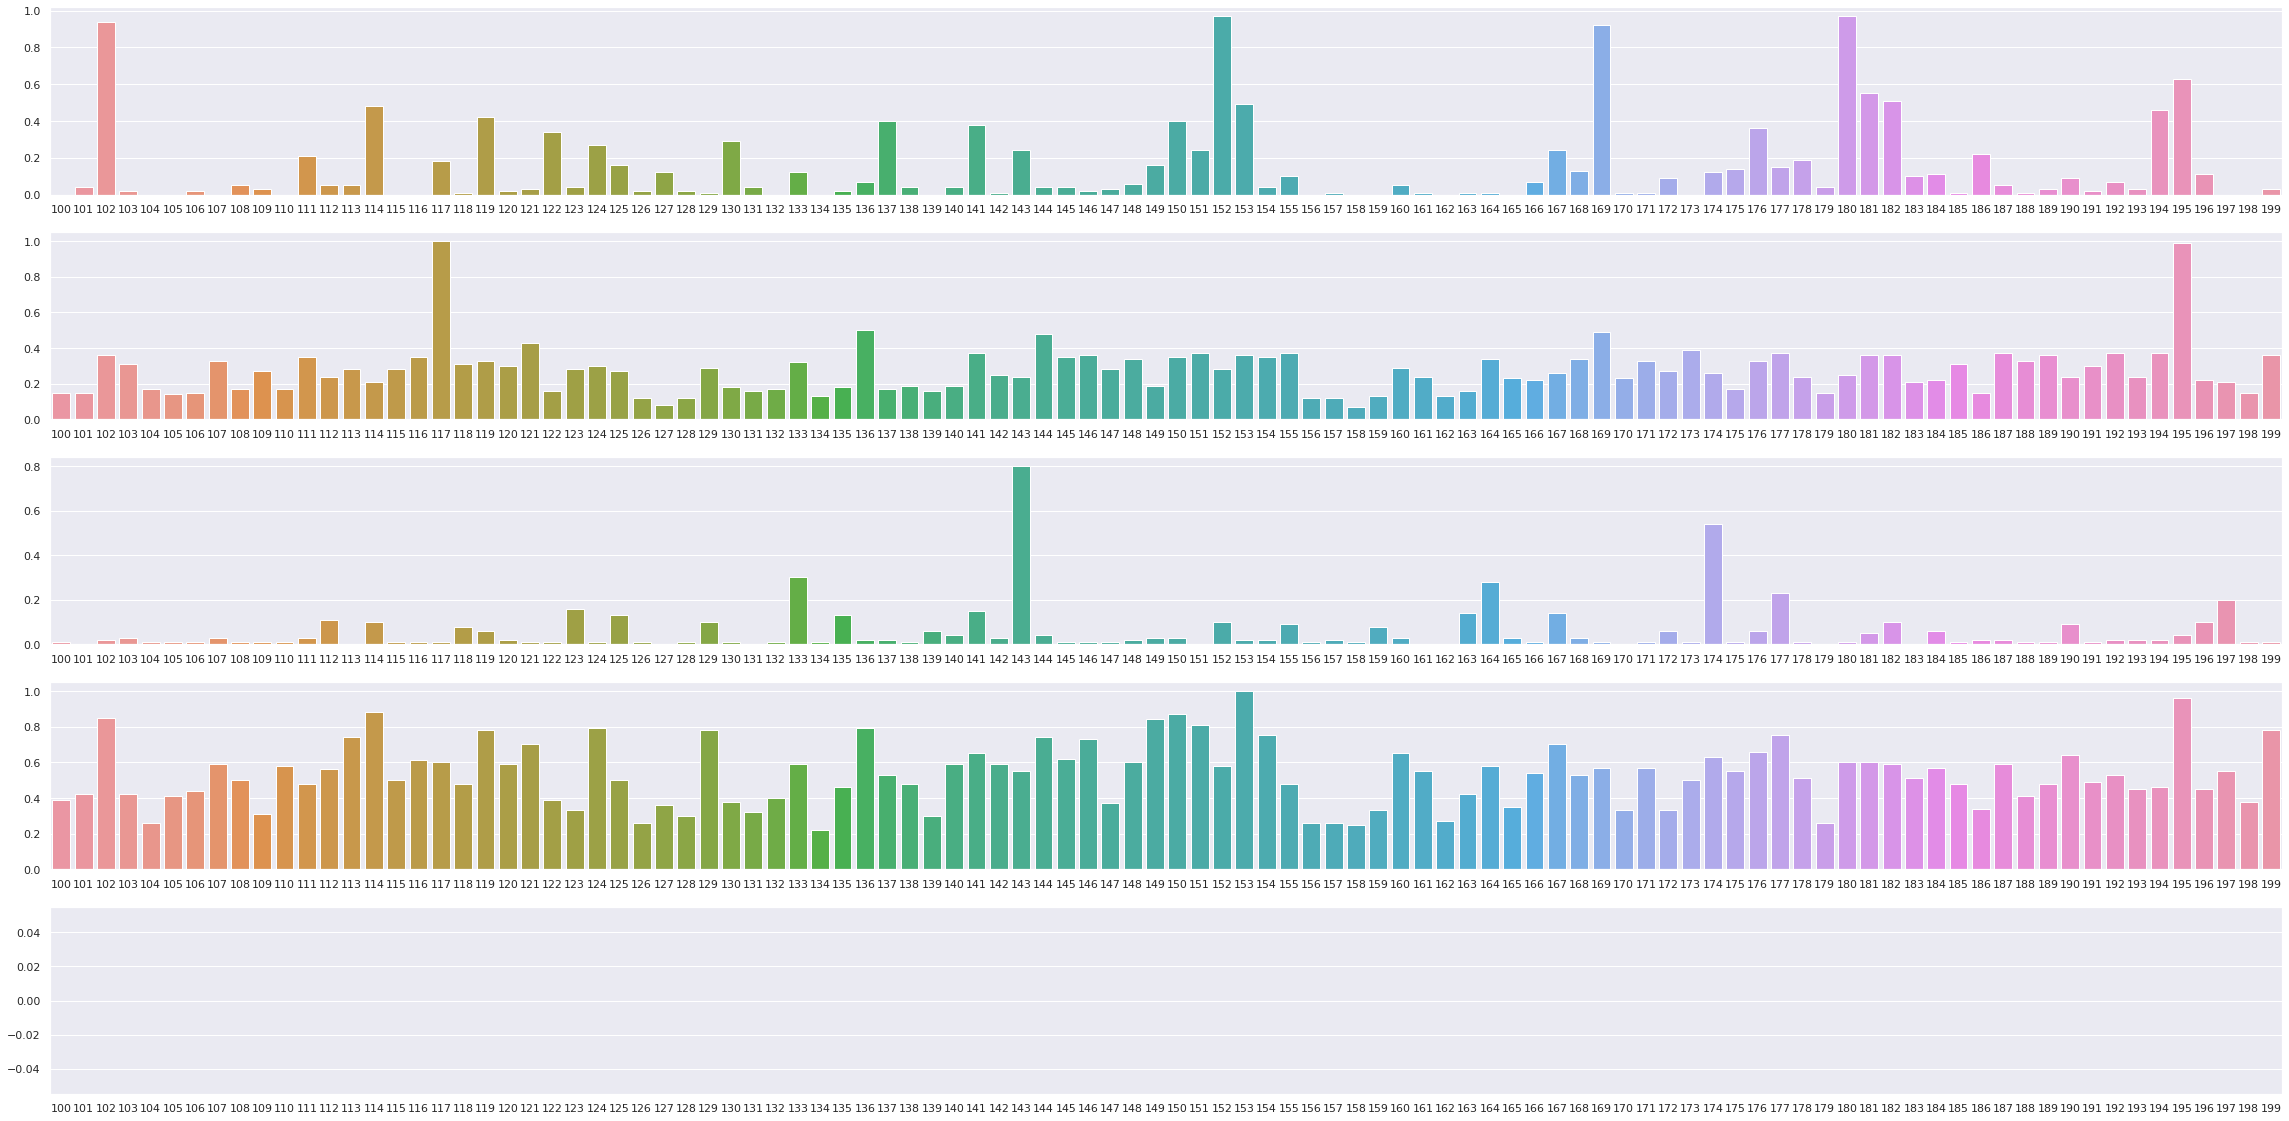

In [195]:
plt.figure(figsize=(40,20))
for i,c in enumerate(Wcode_sum):
    plt.subplot(5,1,i+1)
    sns.barplot(x = x_cor[cut:], y = c[cut:]/repeat)
plt.show()

### 2.3.3 Top 5 Important Features

- Here we treat the importance for each feature on each class as the frequence from above.
- The top 5 important features and their frequencies are shown below.
- For the last class, as *COAD*, there are only top 3 important features, since frequencies for all other features are zero.

In [196]:
t = np.argsort(Wcode_sum,axis=1)
for i,c in enumerate(t):
    pick_label = label_df.Class.unique()[i]
    pick_index = c[::-1][:5]
    pick_value = Wcode_sum[i][pick_index]/repeat
    print("Class : {} \nFeature : {} \nImportance : {}\n".format(pick_label,pick_index,pick_value))

Class : PRAD 
Feature : [ 86  75  98 180 152] 
Importance : [1.   1.   0.98 0.97 0.97]

Class : LUAD 
Feature : [ 58 117  65   3 195] 
Importance : [1.   1.   1.   0.99 0.99]

Class : BRCA 
Feature : [40 33 69 64  6] 
Importance : [1.   0.98 0.96 0.95 0.93]

Class : KIRC 
Feature : [153 195  58 114 150] 
Importance : [1.   0.96 0.92 0.88 0.87]

Class : COAD 
Feature : [98 13 74 63 72] 
Importance : [1. 1. 1. 0. 0.]

